In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn

## 一、可视化原始图片

In [3]:
import numpy as np
import matplotlib.pyplot as plt
def imshow(img,title):
    npimg=img.numpy()
    fig = plt.figure(figsize = (15, 25))
    plt.imshow(np.transpose(npimg,(1,2,0)))#change dimmension，from GBR to RGB
    plt.title(title)
    plt.show()

def cifar_transform(is_training=True):
    # ToTensor() : normalized to [0,1],directly divided by 255
    # Normalize(): transformed into standard Gaussian distribution channel by channel(input[channel] - mean[channel])/std[channel]
    if is_training:
        transform_list = [transforms.RandomHorizontalFlip(),
                          transforms.Pad(padding=4, padding_mode='reflect'),
                          transforms.RandomCrop(32, padding=0),
                          transforms.ToTensor(),
                          transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), ] 
    else:
        transform_list = [transforms.ToTensor(),
                          transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), ]

    transform_list = transforms.Compose(transform_list)
    return transform_list

testset = torchvision.datasets.CIFAR10(root='../cifar_data', train=False,
                                       download=True, transform=cifar_transform(is_training=False))
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=0)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')  

Files already downloaded and verified


tensor([3, 8, 2, 3, 6, 9, 8, 3]) <class 'torch.Tensor'>
True Image & True Label


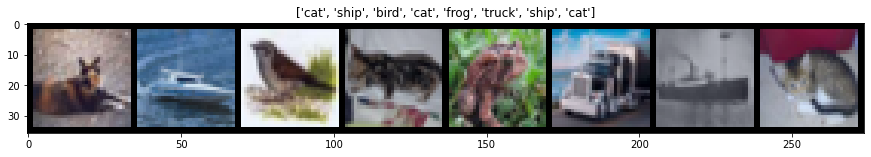

In [15]:
data_iter = iter(testloader)
img, label = data_iter.next()
#print(img[0])
print(label,type(label))
print('True Image & True Label')
imshow(torchvision.utils.make_grid(img,normalize=True),[classes[i] for i in label])

## 二、原始测试集准确度

In [4]:
import torch.backends.cudnn as cudnn
from pytorchcv.model_provider import get_model as ptcv_get_model
from Spatial_RN_cifar import RN18_cifar10
import time
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# get the pre-trained model from pytorchcv package
#model = ptcv_get_model('resnet20_cifar10',pretrained=True).to(device)

model = RN18_cifar10().to(device)
ckpt = torch.load('./checkpoint_94.48%.t7')
criterion = torch.nn.CrossEntropyLoss().to(device)
if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

model.load_state_dict(ckpt['model_state_dict'])
print(ckpt['acc'])


94.48


In [12]:
def test(net,eval_loader,device,criterion):
    net.eval()
    test_loss, correct, total = 0,0,0
    b_time = time.time()
    with torch.no_grad():
        for batch_id,(x,target) in enumerate(eval_loader):
            x,target = x.to(device),target.to(device) 
            y = net(x)
            loss= criterion(y,target)
            test_loss+=loss.item()
            _,predicted = y.max(1)
            correct += torch.eq(target,predicted).float().sum().item()
            total+=y.size(0)
        acc = 100. * correct / total
        t_time = time.time()
        print("Test acc:{0:.3f}% on CIFAR10, Loss: {1:.3f}".format(acc,test_loss))
        print("Consuming time:{:.3f} s".format(t_time-b_time))

In [13]:
test(model,testloader,device,criterion)

Test acc:94.030% on CIFAR10, Loss: 15.715
Consuming time:1.785 s


## 三、对抗测试集准确度

### 3.1 对抗攻击

In [5]:
def FGSM_attack(imgs,grad,epsilon):
    # Collect the element-wise sign of the data gradient
    attack_imgs = imgs + epsilon* grad.sign()
    #Adding clipping to maintain [0,1] range
    # here we omit this, because this makes the visualization quite different in CIFAR10, 
    #attack_imgs = torch.clamp(attack_imgs, 0, 1) 

    return attack_imgs

In [6]:
def FGSM_test(net,eval_loader,device,criterion,ep = 0.1):
    net.eval()
    test_loss, correct, total = 0,0,0
    b_time = time.time()
    #correct2 = 0
    for batch_id,(x,target) in enumerate(eval_loader):
        x,target = x.to(device), target.to(device)
        x.requires_grad = True

        y = net(x)
        _,predicted = y.max(1)

        #if initial prediction is wrong, just skip, this method batchsize should be 1
        #if predicted.item() != target.item():
            #continue
            
        # Calculate the loss
        loss = criterion(y, target).to(device)
        # Zero all existing gradients
        net.zero_grad()
        # Calculate gradients of model in backward pass
        loss.backward()
        data_grad = x.grad.data

        adv_x = FGSM_attack(x,data_grad,ep)
        adv_y = net(adv_x)
        
        loss= criterion(adv_y,target)
        test_loss+=loss.item()
        _,adv_predicted = adv_y.max(1)
        correct += torch.eq(target,adv_predicted).float().sum().item()
        
        total+=target.size(0)
    acc = 100. * correct / total
    #acc2 = 100.* correct2/total
    t_time = time.time()
    print("Test acc:{0:.3f}% with epsilon is {1:.2f} on CIFAR10, Loss: {2:.3f}".format(acc,ep,test_loss))
    print("Consuming time:{:.3f} s".format(t_time-b_time))
    #print('initial acc is {:.2f}'.format(acc2))

In [6]:
ep = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.4]
for i in range(len(ep)):
    FGSM_test(model,testloader,device,criterion,ep[i])

Test acc:94.480% with epsilon is 0.00 on CIFAR10, Loss: 20.275
Consuming time:8.770 s
Test acc:37.500% with epsilon is 0.05 on CIFAR10, Loss: 429.316
Consuming time:6.717 s
Test acc:27.220% with epsilon is 0.10 on CIFAR10, Loss: 527.396
Consuming time:6.761 s
Test acc:24.250% with epsilon is 0.15 on CIFAR10, Loss: 535.977
Consuming time:6.795 s
Test acc:22.690% with epsilon is 0.20 on CIFAR10, Loss: 524.028
Consuming time:6.763 s
Test acc:21.470% with epsilon is 0.25 on CIFAR10, Loss: 507.586
Consuming time:6.781 s
Test acc:19.670% with epsilon is 0.30 on CIFAR10, Loss: 492.214
Consuming time:6.789 s
Test acc:17.370% with epsilon is 0.40 on CIFAR10, Loss: 465.623
Consuming time:6.764 s


测试结果 RN20:
| epsilon | 0    | 0.05 | 0.1    |0.15 | 0.2 |0.25    | 0.3     | 0.4   |
| -       |  -   | - |  -    |   - |  -  | -      | -       | -     |
| acc     |94.030%|43.90%  |38.98% |34.41% |29.02%|24.44%  |20.56%  | 16.56% |

测试结果 RN18:
| epsilon | 0    | 0.05 | 0.1    |0.15 | 0.2 |0.25    | 0.3     | 0.4   |
| -       |  -   | - |  -    |   - |  -  | -      | -       | -     |
| acc     |94.48%|37.50%  |27.22% |24.25% |22.69%|21.47%  |19.67%  | 17.37% |

### 3.2 可视化样例
- 这里是针对于模型的

True Image & True Label


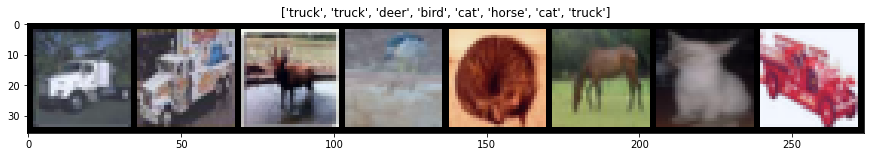

Attack Image & Label


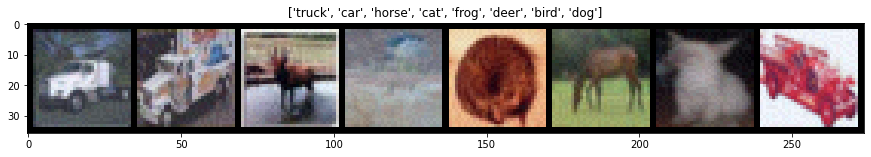

In [10]:
data_iter = iter(testloader)
img, label = data_iter.next()# this operation will apply the normalization to the data
#print(img[0])
print('True Image & True Label')
imshow(torchvision.utils.make_grid(img,normalize=True),[classes[i] for i in label])
print('Attack Image & Label')
attack_img = FGSM_attack(model,img,label,0.1,device,criterion).to(device)
#print(attack_img)
output = model(attack_img).to(device)
_,prediceted = output.max(1)
attack_img = attack_img.cpu().data
imshow(torchvision.utils.make_grid(attack_img.cpu().data,normalize=True),[classes[i] for i in prediceted])